# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
#Refered/code-reusebility from ipynb from applied_ai_course notes 

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
#Natural-Text-pre-processing 
#finding the which sentence contains html tags

import re

i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;


4
I wish I'd read the reviews before making this purchase. It's basically a cardsotck box that is sticky all over the OUTSIDE. Those pink-ish things that look like entrances "into" the trap? They're just pictures. There *is no* inside of the trap. All the flies will be stuck to the OUTSIDE. It's basically fly paper, just horribly, horribly HORRIBLY overpriced.<br /><br />Do yourself a favor and just get fly paper or fly strips. Same yuck factor, but much cheaper.


In [16]:
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

stop = set(stopwords.words('english')) #set of stopwords

sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
sno.stem('delicious')
#stop


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SatyaKrishna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'delici'

In [17]:
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from tqdm import tqdm
import os

final_string=[] #creating a empty list for storing final preprocessed data
cleanedtext_length=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
for i, sent in enumerate(tqdm(final['Text'].values)):
    filtered_sentence=[] #empty list for store after remove html and punc's and alfanumeric and words >2 and not in stop and converted to lowercase 
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
        # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)# above steps are stored here 
                    if (final['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews stored with above 
                    if(final['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews stored with above 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words stored in str1   
    final_string.append(str1) #here str1 stored in final_string
    cleanedtext_length.append(len(str1))
print("filtered sentences are stored successfully")


100%|███████████████████████████████████| 87773/87773 [02:37<00:00, 559.05it/s]


filtered sentences are stored successfully


In [18]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
final['cleanedText_length']=cleanedtext_length#addingcolumn  a length of cleaned text
print("cleaned data is added successfully in cleaned text feature")
final.shape
final.head(3)
#final.CleanedText.values[:50]

cleaned data is added successfully in cleaned text feature


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,cleanedText_length
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...,149
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog love saw pet store tag attach regard made ...,64
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infest fruitfli liter everywher fli around kit...,357


In [19]:
#all the filtered sentences and positive and negative reviews with bytes foramt for faster processing 
# are stored in final_string
#Now most common positive words and negitive words

freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words in review : ",freq_dist_positive.most_common(20))
print('-' *100)
print("Most Common Negative Words in review: ",freq_dist_negative.most_common(20))

Most Common Positive Words in review :  [(b'like', 35242), (b'tast', 30840), (b'good', 27671), (b'flavor', 26981), (b'love', 26733), (b'great', 25050), (b'one', 23767), (b'use', 22755), (b'tri', 21157), (b'product', 20972), (b'coffe', 20647), (b'tea', 19247), (b'food', 18115), (b'get', 17728), (b'make', 17278), (b'dog', 14274), (b'would', 13929), (b'eat', 13453), (b'time', 12997), (b'realli', 12951)]
----------------------------------------------------------------------------------------------------
Most Common Negative Words in review:  [(b'tast', 8828), (b'like', 8406), (b'product', 6907), (b'one', 5184), (b'flavor', 4936), (b'would', 4561), (b'tri', 4539), (b'coffe', 3871), (b'good', 3846), (b'use', 3690), (b'food', 3625), (b'get', 3456), (b'buy', 3385), (b'dog', 3214), (b'dont', 3017), (b'order', 3009), (b'tea', 2865), (b'even', 2835), (b'eat', 2693), (b'box', 2677)]


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [20]:
## Similartly you can do preprocessing for review summary also.
## Similartly you can do preprocessing for review summary also.
## Similartly you can do preprocessing for review summary also.
#finding html tags in summary text 

j=0;
for summary in final['Summary'].values:
    if (len(re.findall('<.*?>', summary))):
        print(j)
        print(summary)
    else:
        print("There is no html tags")
        print('-'*50)
        break;
    j += 1;
final["Summary"].head(10)

There is no html tags
--------------------------------------------------


22620                              made in china
22621                          Dog Lover Delites
70677                    only one fruitfly stuck
70676    Doesn't work!! Don't waste your money!!
70675                              A big rip off
70673     THIS ITEM IS EXCELLENT TO KILL INSECTS
70672                                Didn't work
70671                        Gross but effective
70670                        Didn't work for me.
70669                             Waste of money
Name: Summary, dtype: object

In [21]:
#removing if any html tags and punctuations in summary feature
#observed there is no html tags in summary attribute 

#def cleanhtml(s_sentence): #function to clean the word of any html-tags
#    s_cleanr = re.compile('<.*?>')
#    s_cleantext = re.sub(s_cleanr, ' ', s_sentence)
#    return s_cleantext

def cleanpunc(s_sentence): #function to clean the word of any punctuation or special characters
    s_cleaned = re.sub(r'[?|!|\'|"|#]',r'',s_sentence)
    s_cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',s_cleaned)
    return  s_cleaned

s_stop = set(stopwords.words('english')) #set of stopwords

s_sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
s_sno.stem('wow')

'wow'

In [22]:
summary_final_string=[] #creating a empty list for storing final preprocessed data
summary_length=[]
summary_all_positive_words=[] # store words from +ve summary here
summary_all_negative_words=[] # store words from -ve summary here.
for j, summary_sent in enumerate(tqdm(final['Summary'].values)):
    summary_filtered_sentence=[] #empty list for store after remove  punc's and alphanumeric and words >2 and not in stop and converted to lowercase 
    #summary_sent=cleanhtml(summary_sent) # remove HTMl tags
    for s_w in summary_sent.split():
        for s_cleaned_words in cleanpunc(s_w).split():
            if((s_cleaned_words.isalpha()) & (len(s_cleaned_words)>2)):    
                if(s_cleaned_words.lower() not in s_stop):
                    s_s=(s_sno.stem(s_cleaned_words.lower())).encode('utf8')
                    summary_filtered_sentence.append(s_s)# above steps are stored here 
                    if (final['Score'].values)[j] == 1: 
                        summary_all_positive_words.append(s_s) #list of all words used to describe positive summary stored with above 
                    if(final['Score'].values)[j] == 0:
                        summary_all_negative_words.append(s_s) #list of all words used to describe negative summary reviews stored with above 
    s_str1 = b''.join(summary_filtered_sentence) #final string of cleaned words stored in s_str1   
    summary_final_string.append(s_str1) #here s_str1 stored in summary_final_string
    summary_length.append(len(s_str1))
print("filtered summary are stored successfully in summary_final_string")
len(summary_final_string)

100%|██████████████████████████████████| 87773/87773 [00:13<00:00, 6734.33it/s]


filtered summary are stored successfully in summary_final_string


87773

In [23]:
s_freq_dist_positive=nltk.FreqDist(summary_all_positive_words)
s_freq_dist_negative=nltk.FreqDist(summary_all_negative_words)
print("Most Common Positive Words in summary : ",s_freq_dist_positive.most_common(10))
print('-' *100)
print("Most Common Negative Words in summary : ",s_freq_dist_negative.most_common(10))

Most Common Positive Words in summary :  [(b'great', 11454), (b'good', 7357), (b'love', 5977), (b'best', 5254), (b'tast', 3462), (b'coffe', 3401), (b'tea', 3154), (b'delici', 3094), (b'dog', 3090), (b'product', 2722)]
----------------------------------------------------------------------------------------------------
Most Common Negative Words in summary :  [(b'tast', 1075), (b'like', 667), (b'good', 659), (b'disappoint', 453), (b'flavor', 431), (b'product', 429), (b'bad', 420), (b'dog', 413), (b'coffe', 399), (b'dont', 355)]


In [24]:
final['Cleanedsummary']=summary_final_string
final['Cleanedsummary_len']=summary_length
final[0:1]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,cleanedText_length,Cleanedsummary,Cleanedsummary_len
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...,149,b'madechina',9


In [25]:
print(final['Score'].value_counts())
print(final['Score'].shape)

1    73592
0    14181
Name: Score, dtype: int64
(87773,)


<h3>Feature_Engineering</h3>

In [26]:
#here combining both cleaned summary text and cleaned review text and cleaned text length for getting better results 
final['cleaned_&_summary'] = final['CleanedText'] + final['Cleanedsummary'].map(str)
fea_eng_x=final['cleaned_&_summary'] + final['cleanedText_length'].map(str)
final.iloc[:,10:15].head(3)

,CleanedText,cleanedText_length,Cleanedsummary,Cleanedsummary_len,cleaned_&_summary
22620,dog love chicken product china wont buy anymor...,149,b'madechina',9,dog love chicken product china wont buy anymor...
22621,dog love saw pet store tag attach regard made ...,64,b'dogloverdelit',13,dog love saw pet store tag attach regard made ...
70677,infest fruitfli liter everywher fli around kit...,357,b'onefruitflistuck',16,infest fruitfli liter everywher fli around kit...


In [27]:
#https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

from imblearn.over_sampling import SMOTE
from sklearn import model_selection
from sklearn.model_selection import train_test_split

X=fea_eng_x
Y=final['Score']

#here we splitting the whole data to train test and cv

#splitted the data in to train and test
x_train,x_test_data,y_train,y_test_data = train_test_split(X, Y, test_size=0.3, random_state=0)
#splitted the above train data into 2nd train and cross validation 
x_train_data,x_cv_data,y_train_data,y_cv_data = train_test_split(x_train, y_train, test_size=0.3, random_state=0)

print("Data splitted sucessfully in to train ,test,cv")

Data splitted sucessfully in to train ,test,cv


# [4] Featurization

## [4.1] BAG OF WORDS

In [422]:
#APPLYING_BOW ON TRAIN DATA 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
count_vect = CountVectorizer() #in scikit-learn
final_counts_bow_train = count_vect.fit_transform(x_train_data)
final_bow_train_data=final_counts_bow_train
#transform  on testdata
final_bow_test_data = count_vect.transform(x_test_data)
#transform on cv data 
final_bow_cv_data = count_vect.transform(x_cv_data)

print("the type of count vectorizer ",type(final_bow_train_data))
print("the shape of out text BOW vectorizer ",final_bow_train_data.get_shape())
print("the number of unique words ", final_bow_train_data.get_shape()[1])
#dense_bow=final_bow_train_data.todense()
print('-' * 50 )
print('-' * 50 )
#print("the type of count vectorizer ",type(dense_bow))

print(final_bow_train_data.shape,y_train_data.shape)
print(final_bow_test_data.shape,y_test_data.shape)
print(final_bow_cv_data.shape,y_cv_data.shape)
print("Bow splitted data\n", "final_bow_train_data,y_train_data\n","final_bow_test_data,y_test_data\n","final_bow_cv_data,y_cv_data\n")


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (43008, 57624)
the number of unique words  57624
--------------------------------------------------
--------------------------------------------------
(43008, 57624) (43008,)
(26332, 57624) (26332,)
(18433, 57624) (18433,)
Bow splitted data
 final_bow_train_data,y_train_data
 final_bow_test_data,y_test_data
 final_bow_cv_data,y_cv_data



In [29]:
final_bow_train_data 

<43008x57624 sparse matrix of type '<class 'numpy.int64'>'
	with 1457373 stored elements in Compressed Sparse Row format>

## [4.3] TF-IDF

In [30]:
#TFIDF VECTORIZER
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tfidf_train_data = tf_idf_vect.fit_transform(x_train_data)
final_tfidf_test_data = tf_idf_vect.transform(x_test_data)
final_tfidf_cv_data = tf_idf_vect.transform(x_cv_data)
print("the type of count vectorizer ",type(final_tfidf_train_data))
print("the shape of out text TFIDF vectorizer ",final_tfidf_train_data.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tfidf_train_data.get_shape()[1])
#tfidf_dense=final_tfidf_train_data.todense()
#print('-' * 50 )
#print("here below  we converting scipy to dense ")
#print('-' * 50 )
#print("the type of count vectorizer ",type(tfidf_dense))
print(final_tfidf_train_data.shape,y_train_data.shape)
print(final_tfidf_test_data.shape,y_test_data.shape)
print(final_tfidf_cv_data.shape,y_cv_data.shape)
print("TFIDF splitted data\n", "final_tfidf_train_data,y_train_data\n","final_tfidf_test_data,y_test_data\n","final_tfidf_cv_data,y_cv_data\n")

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (43008, 822825)
the number of unique words including both unigrams and bigrams  822825
(43008, 822825) (43008,)
(26332, 822825) (26332,)
(18433, 822825) (18433,)
TFIDF splitted data
 final_tfidf_train_data,y_train_data
 final_tfidf_test_data,y_test_data
 final_tfidf_cv_data,y_cv_data



## [4.4] Word2Vec

In [31]:
#spplitting the data 
X=fea_eng_x
Y=final['Score']

#here we splitting the whole data to train test and cv

#splitted the data in to train and test
x_train,x_test_data,y_train,y_test_data = train_test_split(X, Y, test_size=0.3, random_state=0)
#splitted the above train data into 2nd train and cross validation 
x_train_data,x_cv_data,y_train_data,y_cv_data = train_test_split(x_train, y_train, test_size=0.3, random_state=0)

print("Data splitted sucessfully in to train ,test,cv")

# Train your own Word2Vec model using your own text corpus
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

#train data
cleantext_train= x_train_data # building own text corpus from w2v train data  
i=0
list_of_sentance_train=[]
for sentance_train in cleantext_train:
    list_of_sentance_train.append(sentance_train.split())
print("cleantext train data")
    
#cv data
cleantext_cv= x_cv_data # building own text corpus from w2v cv data  
j=0
list_of_sentance_cv=[]
for sentance_cv in cleantext_cv:
    list_of_sentance_cv.append(sentance_cv.split())
print("cleantext cv data")


#test data
cleantext_test= x_test_data # building own text corpus from w2v test data  
k=0
list_of_sentance_test=[]
for sentance_test in cleantext_test:
    list_of_sentance_test.append(sentance_test.split())
print("cleantext test data")

Data splitted sucessfully in to train ,test,cv
cleantext train data
cleantext cv data
cleantext test data


In [32]:
#WORD2VEC USING OWN CORPUS FROM ABOVE DATA 
# min_count = 5 considers only words that occured atleast 5 times
w2v_train_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
#w2v_cv_model=Word2Vec(list_of_sentance_cv,min_count=5,size=50, workers=4)
#w2v_test_model=Word2Vec(list_of_sentance_test,min_count=5,size=50, workers=4)

#w2v_train_model.wv.most_similar('like')  

In [33]:
#creating words only on train data 
w2v_words_train = list(w2v_train_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words from corpus  ", w2v_words_train[0:50])

number of words that occured minimum 5 times  8475
sample words from corpus   ['doubl', 'dye', 'spill', 'anyth', 'want', 'wear', 'compani', 'crazi', 'cours', 'mix', 'batch', 'add', 'least', 'ounc', 'lemon', 'juic', 'lime', 'take', 'bring', 'refresh', 'qualiti', 'counteract', 'sicken', 'sweet', 'american', 'appar', 'crave', 'keep', 'jug', 'refriger', 'time', 'rare', 'day', 'pass', 'dont', 'glass', 'store', 'around', 'stop', 'carri', 'realli', 'like', 'except', 'safeway', 'hit', 'cannist', 'delight', 'find', 'sign', 'price']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [34]:
# average Word2Vec train data 
# compute average word2vec_train for each review.
sent_vectors_train = []; # the avg-w2v_train for each sentence/review is stored in this list
final_avgw2v_train_data=sent_vectors_train
for sent_train in tqdm(list_of_sentance_train): # for each train_review/sentence
    sent_vec_train = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words_train =0; # num of words with a valid vector in the train_sentence/review
    for word_train in sent_train: # for each word in a train_review/sentence
        if word_train in w2v_words_train:
            vec_train = w2v_train_model.wv[word_train]
            sent_vec_train += vec_train
            cnt_words_train += 1
    if cnt_words_train != 0:
        sent_vec_train /= cnt_words_train
    sent_vectors_train.append(sent_vec_train)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))
print(type(sent_vectors_train))

100%|███████████████████████████████████| 43008/43008 [01:20<00:00, 531.87it/s]


43008
50
<class 'list'>


In [35]:
# average Word2Vec cv data 
# compute average word2vec_train for each review.
sent_vectors_cv = []; # the avg-cv for each sentence/review is stored in this list
final_avgw2v_cv_data=sent_vectors_cv
for sent_cv in tqdm(list_of_sentance_cv): # for each train_review/sentence
    sent_vec_cv = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words_cv =0; # num of words with a valid vector in the train_sentence/review
    for word_cv in sent_cv: # for each word in a train_review/sentence
        if word_cv in w2v_words_train:
            vec_cv = w2v_train_model.wv[word_cv]
            sent_vec_cv += vec_cv
            cnt_words_cv += 1
    if cnt_words_cv != 0:
        sent_vec_cv /= cnt_words_cv
    sent_vectors_cv.append(sent_vec_cv)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))
print(type(sent_vectors_cv))

100%|███████████████████████████████████| 18433/18433 [00:34<00:00, 532.27it/s]


18433
50
<class 'list'>


In [366]:
# average Word2Vec test data 
# compute average word2vec_train for each review.
sent_vectors_test = []; # the avg-w2v_train for each sentence/review is stored in this list
final_avgw2v_test_data=sent_vectors_test
for sent_test in tqdm(list_of_sentance_test): # for each train_review/sentence
    sent_vec_test = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words_test =0; # num of words with a valid vector in the train_sentence/review
    for word_test in sent_test: # for each word in a train_review/sentence
        if word_test in w2v_words_train:
            vec_test = w2v_train_model.wv[word_test]
            sent_vec_test += vec_test
            cnt_words_test += 1
    if cnt_words_test != 0:
        sent_vec_test /= cnt_words_test
    sent_vectors_test.append(sent_vec_test)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))
print(type(sent_vectors_test))

100%|███████████████████████████████████| 26332/26332 [00:41<00:00, 635.02it/s]


26332
50
<class 'list'>


#### [4.4.1.2] TFIDF weighted W2v

In [36]:
#tfidf_traindata using  train model
tfidfw2v_model_train = TfidfVectorizer()
final_tfidfw2v_train=tfidfw2v_model_train.fit(x_train_data)
dictionary_train = dict(zip(final_tfidfw2v_train.get_feature_names(), list(final_tfidfw2v_train.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat_train = final_tfidfw2v_train.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = [];# the tfidf-w2v for each sentence/review is stored in this list
final_tfidfw2v_train_data=tfidf_sent_vectors_train
row=0;''
for sent_train in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec_train = np.zeros(50) # as word vectors are of zero length
    weight_sum_train =0; # num of words with a valid vector in the sentence/review
    for word in sent_train: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat_train:
            vec_train = w2v_train_model.wv[word]
             #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf_train = dictionary_train[word]*(sent_train.count(word)/len(sent_train))
            sent_vec_train += (vec_train * tf_idf_train)
            weight_sum_train += tf_idf_train
    if weight_sum_train != 0:
        sent_vec_train /= weight_sum_train
    tfidf_sent_vectors_train.append(sent_vec_train)
    row += 1
print(len(sent_vec_train))
print(len(tfidf_sent_vectors_train))  
print(type(tfidf_sent_vectors_train))  

100%|████████████████████████████████████| 43008/43008 [39:49<00:00, 22.75it/s]


50
43008
<class 'list'>


In [37]:
#tfidf_cv_data using  train model
tfidfw2v_model_train = TfidfVectorizer()
final_tfidfw2v_train=tfidfw2v_model_train.fit(x_train_data)
dictionary_train = dict(zip(final_tfidfw2v_train.get_feature_names(), list(final_tfidfw2v_train.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat_cv = final_tfidfw2v_train.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = [];# the tfidf-w2v for each sentence/review is stored in this list
final_tfidfw2v_cv_data=tfidf_sent_vectors_cv
row=0;
for sent_cv in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec_cv = np.zeros(50) # as word vectors are of zero length
    weight_sum_cv =0; # num of words with a valid vector in the sentence/review
    for word_cv in sent_cv: # for each word in a review/sentence
        if word_cv in w2v_words_train and word_cv in tfidf_feat_cv:
            vec_cv = w2v_train_model.wv[word_cv]
             #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf_cv = dictionary_train[word_cv]*(sent_cv.count(word_cv)/len(sent_cv))
            sent_vec_cv += (vec_cv * tf_idf_cv)
            weight_sum_cv += tf_idf_cv
    if weight_sum_cv != 0:
        sent_vec_cv /= weight_sum_cv
    tfidf_sent_vectors_cv.append(sent_vec_cv)
    row += 1
print(len(sent_vec_cv))
print(len(tfidf_sent_vectors_cv))  
print(type(tfidf_sent_vectors_cv))  

100%|████████████████████████████████████| 18433/18433 [14:47<00:00, 20.78it/s]


50
18433
<class 'list'>


In [38]:
#tfidf_test_data using  train model
tfidfw2v_model_train = TfidfVectorizer()
final_tfidfw2v_train=tfidfw2v_model_train.fit(x_train_data)
dictionary_train = dict(zip(final_tfidfw2v_train.get_feature_names(), list(final_tfidfw2v_train.idf_))) 

In [39]:
#tfidfw2v on test data 
tfidf_feat_test = final_tfidfw2v_train.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
final_tfidfw2v_test_data=tfidf_sent_vectors_test
row=0;
for sent_test in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec_test = np.zeros(50) # as word vectors are of zero length
    weight_sum_test =0; # num of words with a valid vector in the sentence/review
    for word_test in sent_test: # for each word in a review/sentence
        if word_test in w2v_words_train and word_test in tfidf_feat_test:
            vec_test = w2v_train_model.wv[word_test]
             #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf_test = dictionary_train[word_test]*(sent_test.count(word_test)/len(sent_test))
            sent_vec_test += (vec_test * tf_idf_test)
            weight_sum_test += tf_idf_test
    if weight_sum_test != 0:
        sent_vec_test /= weight_sum_test
    tfidf_sent_vectors_test.append(sent_vec_test)
    row += 1
print(len(sent_vec_test))
print(len(tfidf_sent_vectors_test))  
print(type(tfidf_sent_vectors_test)) 

100%|████████████████████████████████████| 26332/26332 [21:59<00:00, 19.95it/s]


50
26332
<class 'list'>


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

C =  0.0001 	 cv_auc_score	: 0.8601664773270197 	 train_auc_score	: 0.8713549275492358
C =  0.001 	 cv_auc_score	: 0.9034136434256674 	 train_auc_score	: 0.917464411231701
C =  0.01 	 cv_auc_score	: 0.9301624693429029 	 train_auc_score	: 0.9555527656528023
C =  0.1 	 cv_auc_score	: 0.9363209846723362 	 train_auc_score	: 0.9820243823107915
C =  1 	 cv_auc_score	: 0.9304976182134124 	 train_auc_score	: 0.9974311525017185
C =  10 	 cv_auc_score	: 0.9214491516876002 	 train_auc_score	: 0.9999900440227171
C =  100 	 cv_auc_score	: 0.9147899701303436 	 train_auc_score	: 1.0
C =  1000 	 cv_auc_score	: 0.91092980807684 	 train_auc_score	: 1.0
C =  10000 	 cv_auc_score	: 0.9087171000244194 	 train_auc_score	: 1.0


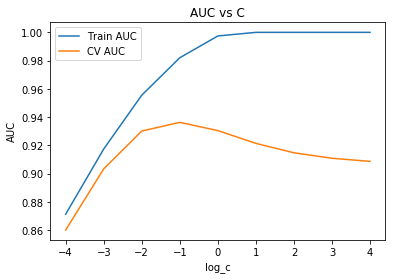

In [867]:
# Please write all the code with proper documentation
#finding the best hyper parameter lambda with representaion as 'C'
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.linear_model import LogisticRegression

train_auc = []
cv_auc = []
C = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
for i in C:
    lg_bow_l1 = LogisticRegression(C=i,class_weight='balanced')# The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies
    lg_bow_l1.fit(final_bow_train_data, y_train_data)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  lg_bow_l1.predict_proba(final_bow_train_data)[:,1]
    y_cv_pred =  lg_bow_l1.predict_proba(final_bow_cv_data)[:,1]
    train_auc_score=roc_auc_score(y_train_data,y_train_pred)
    train_auc.append(train_auc_score)
    cv_auc_score=roc_auc_score(y_cv_data, y_cv_pred)
    cv_auc.append(cv_auc_score)
    print("C = ",i ,"\t","cv_auc_score\t:",cv_auc_score, "\t","train_auc_score\t:",train_auc_score)
#plotting
log_c = [math.log10(num) for num in C]

plt.plot(log_c, train_auc, label='Train AUC')
plt.plot(log_c, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log_c")
plt.ylabel("AUC")
plt.title("AUC vs C")
plt.show()

Here we got optimal C = 0.1 <br>
At    cv_auc    = 0.936<br>
      train_auc = 0.951


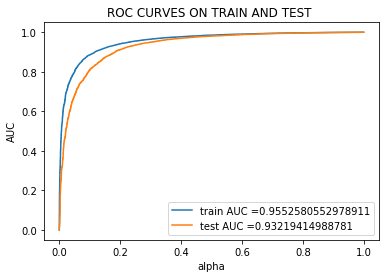

In [868]:
#performing the nb with optimal alpha for bow vectorizer 
from sklearn.metrics import roc_curve, auc

lg_bow_l1 = LogisticRegression(C=0.1,penalty= 'l1' ,class_weight='balanced')
lg_bow_l1.fit(final_bow_train_data, y_train_data)


bow_train_fpr, bow_train_tpr, bow_thresholds = roc_curve(y_train_data, lg_bow_l1.predict_proba(final_bow_train_data)[:,1])
bow_test_fpr, bow_test_tpr, bow_thresholds = roc_curve(y_test_data, lg_bow_l1.predict_proba(final_bow_test_data)[:,1])

plt.plot(bow_train_fpr, bow_train_tpr, label="train AUC ="+str(auc(bow_train_fpr, bow_train_tpr)))
plt.plot(bow_test_fpr, bow_test_tpr, label="test AUC ="+str(auc(bow_test_fpr, bow_test_tpr)))
plt.legend()
plt.xlabel("alpha")
plt.ylabel("AUC")
plt.title("ROC CURVES ON TRAIN AND TEST ")
plt.show()

Bow train confusion matrix
[[ 6309  4002]
 [  731 31966]]


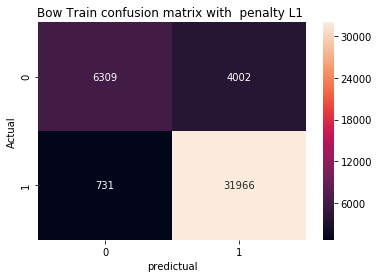

In [871]:
#Bow Train data confusion matrix
from sklearn.metrics import confusion_matrix
print("Bow train confusion matrix")
bow_cm_train = confusion_matrix(lg_bow_l1.predict(final_bow_train_data),y_train_data)
sns.heatmap(bow_cm_train, annot=True, fmt="d")
plt.title("Bow Train confusion matrix with  penalty L1 ")
plt.xlabel("predictual")
plt.ylabel("Actual")
print(bow_cm_train)

Bow Train confusion matrix with  penalty L1 <br>
31966+6309 are correctly predicted <br>
731+4002 are in-correctly predicted 

Bow test confusion matrix
[[ 3556  2652]
 [  672 19452]]


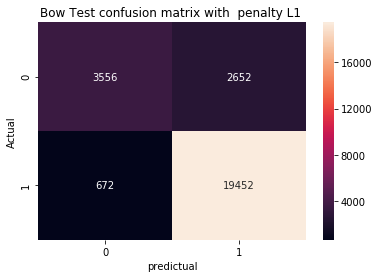

In [880]:
#Bow Test data confusion matrix
from sklearn.metrics import confusion_matrix
print("Bow test confusion matrix")
bow_cm_test = confusion_matrix(lg_bow_l1.predict(final_bow_test_data),y_test_data)
sns.heatmap(bow_cm_test, annot=True, fmt="d")
plt.title("Bow Test confusion matrix with  penalty L1 ")
plt.xlabel("predictual")
plt.ylabel("Actual")
print(bow_cm_test)

Bow Test confusion matrix with  penalty L1 <br>
19452+3556 are correctly predicted <br>
672+2652 are in-correctly predicted 

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [205]:
# Please write all the code with proper documentation
clf = LogisticRegression(C=0.1, penalty='l1',class_weight='balanced');
clf.fit(final_bow_train_data, y_train_data);
feature_weights = clf.coef_
print(np.count_nonzero(w))

1013


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [249]:
#caluclating hypermater twice because of getting correct to 10 positive and negative features for clear view by changing model fit names 
train_auc = []
cv_auc = []
C = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
for i in C:
    lg_bow_l2 = LogisticRegression(C=i,class_weight='balanced')# The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies
    lg_bow_l2.fit(final_bow_train_data, y_train_data)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  lg_bow_l2.predict_proba(final_bow_train_data)[:,1]
    y_cv_pred =  lg_bow_l2.predict_proba(final_bow_cv_data)[:,1]
    train_auc_score=roc_auc_score(y_train_data,y_train_pred)
    train_auc.append(train_auc_score)
    cv_auc_score=roc_auc_score(y_cv_data, y_cv_pred)
    cv_auc.append(cv_auc_score)
    print("C = ",i ,"\t","cv_auc_score\t:",cv_auc_score, "\t","train_auc_score\t:",train_auc_score)

C =  0.0001 	 cv_auc_score	: 0.8600401329270494 	 train_auc_score	: 0.8711594886742761
C =  0.001 	 cv_auc_score	: 0.9033159875212786 	 train_auc_score	: 0.9173064978212957
C =  0.01 	 cv_auc_score	: 0.9301240263164414 	 train_auc_score	: 0.955449963572418
C =  0.1 	 cv_auc_score	: 0.9363254748532175 	 train_auc_score	: 0.9819527869469832
C =  1 	 cv_auc_score	: 0.9305209317634069 	 train_auc_score	: 0.9974052100920516
C =  10 	 cv_auc_score	: 0.9214714477581831 	 train_auc_score	: 0.9999896885931434
C =  100 	 cv_auc_score	: 0.9148055751678399 	 train_auc_score	: 1.0
C =  1000 	 cv_auc_score	: 0.9108786023194992 	 train_auc_score	: 1.0
C =  10000 	 cv_auc_score	: 0.9090155864574375 	 train_auc_score	: 1.0


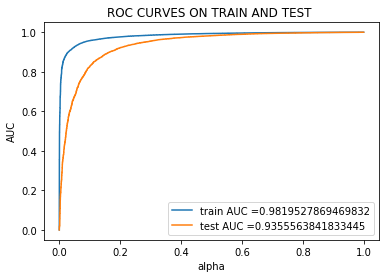

In [250]:
#applying log regression with l2 penality 
lg_bow_l2 = LogisticRegression(C=0.1,penalty= 'l2' ,class_weight='balanced')
lg_bow_l2.fit(final_bow_train_data, y_train_data)


bow_train_fpr, bow_train_tpr, bow_thresholds = roc_curve(y_train_data, lg_bow_l2.predict_proba(final_bow_train_data)[:,1])
bow_test_fpr, bow_test_tpr, bow_thresholds = roc_curve(y_test_data, lg_bow_l2.predict_proba(final_bow_test_data)[:,1])

plt.plot(bow_train_fpr, bow_train_tpr, label="train AUC ="+str(auc(bow_train_fpr, bow_train_tpr)))
plt.plot(bow_test_fpr, bow_test_tpr, label="test AUC ="+str(auc(bow_test_fpr, bow_test_tpr)))
plt.legend()
plt.xlabel("alpha")
plt.ylabel("AUC")
plt.title("ROC CURVES ON TRAIN AND TEST ")
plt.show()

Bow train confusion matrix
[[ 6679  2609]
 [  361 33359]]


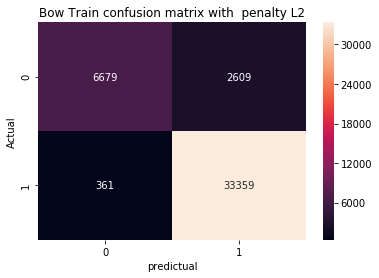

In [251]:
#Bow Train data confusion matrix
from sklearn.metrics import confusion_matrix
print("Bow train confusion matrix")
bow_cm_train = confusion_matrix(lg_bow_l2.predict(final_bow_train_data),y_train_data)
sns.heatmap(bow_cm_train, annot=True, fmt="d")
plt.title("Bow Train confusion matrix with  penalty L2")
plt.xlabel("predictual")
plt.ylabel("Actual")
print(bow_cm_train)

Bow train confusion matrix with  penalty L2 <br>
33359+6679 are correctly predicted <br>
361+2609 are in-correctly predicted 

Bow test confusion matrix
[[ 3511  2152]
 [  717 19952]]


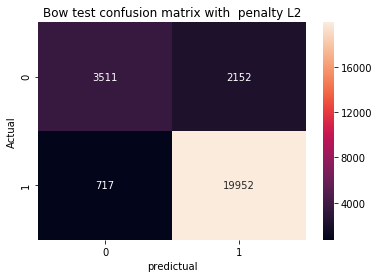

In [879]:
#Bow Test data confusion matrix
from sklearn.metrics import confusion_matrix
print("Bow test confusion matrix")
bow_cm_test = confusion_matrix(lg_bow_l2.predict(final_bow_test_data),y_test_data)
sns.heatmap(bow_cm_test, annot=True, fmt="d")
plt.title("Bow test confusion matrix with  penalty L2")
plt.xlabel("predictual")
plt.ylabel("Actual")
print(bow_cm_test)

Bow Test confusion matrix with  penalty L2 <br>
19952+3511 are correctly predicted <br>
717+2152 are in-correctly predicted 

#### [5.1.2.1] Performing pertubation test  with  penalty L1(multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [838]:
#fitting the model with 
from sklearn.linear_model import LogisticRegression
#applying lg on above bow fitted data
clf = LogisticRegression(C= 0.1, penalty= 'l1' ,class_weight='balanced')
clf.fit(final_bow_train_data,y_train_data) #fitting the lg model 
fea_wei=clf.coef_ #feature_weights 
weight = fea_wei + 0.000001 #here avoiding divisible by zero errors

In [839]:
# Please write all the code with proper documentation
#adding noise to final_bow_train_data
e = np.random.normal(0, 0.001) # here adding noise to data 
final_bow_train_data.data = final_bow_train_data.data + e

In [840]:
#applying lg on noisy bow  data 
noise_clf = LogisticRegression(C= 0.1, penalty= 'l1' ,class_weight='balanced')
noise_clf.fit(final_bow_train_data,y_train_data) #fitting the lg noise model 
fea_wei_noise=noise_clf.coef_ #feature_weights 
noise_weight = fea_wei_noise + 0.000001 #here avoiding divisible by zero errors

In [857]:
#difference between weights 
weight_diff=abs(((weight-noise_weight) / (weight))*100)


In [858]:
#checking percentiles of wei_diff
p=np.arange(99,100,0.1)
for i in p:
    per=np.percentile(wei_diff,i)
    print(i,"th","value is ",per)

99.0 th value is  0.4325787370135392
99.1 th value is  0.4870731057933746
99.19999999999999 th value is  0.5389048576589717
99.29999999999998 th value is  0.5925089597634816
99.39999999999998 th value is  0.6531662589559211
99.49999999999997 th value is  0.805123257901815
99.59999999999997 th value is  1.1539263117826848
99.69999999999996 th value is  1.9956225095257927
99.79999999999995 th value is  3.9168559635521394
99.89999999999995 th value is  10.06324924022942


In [859]:
p = np.percentile(wei_diff,99.9)#here 99.8th percentile  is threshold  because there is a sudden change at 99.9 percentile 
print("Threshold--->",p)#here it is a threshold value 

Threshold---> 10.063249240230341


In [864]:
df = pd.DataFrame()
df['features'] = count_vect.get_feature_names()
df['wei_diff'] = weight_diff[0]
df = df.sort_values('wei_diff',ascending = False)[:10]
print("Features contain more differences between weights weight and noise_weight\n ",df)


Features contain more differences between weights weight and noise_weight
         features    wei_diff
19895    flimsi  100.169334
29489    island   20.181429
41626   process   15.846397
46272  shouldnt   14.506533
51869    thrill   14.173046
1047         67    9.870603
4564    barbecu    9.574431
1351         96    8.902849
47268    sodium    7.950741
52982      tube    6.535008


Above Features are   more weight's diffrences  

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [353]:
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
def show_most_informative_features(count_vect, lg_bow_l1, n=10):
    feature_names = count_vect.get_feature_names()
    coefs_with_fns = sorted(zip(lg_bow_l1.coef_[0], feature_names))
    top = coefs_with_fns[:-(n + 1):-1]
    print("BOW Positive_Features")
    print("_________________")
    for (coef_1, fn_1) in top:
        print("%.4f\t%-15s" % (coef_1, fn_1))
show_most_informative_features(count_vect,lg_bow_l1)

BOW Positive_Features
_________________
1.7485	doglove        
1.5887	greatproduct   
1.5052	yummi          
1.5017	delici         
1.4143	perfect        
1.3895	loveb          
1.3867	awesom         
1.3026	excel          
1.2777	yum            
1.2481	amaz           


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [354]:
# Please write all the code with proper documentation
def show_most_informative_features(count_vect, lg_bow_l1, n=10):
    feature_names = count_vect.get_feature_names()
    coefs_with_fns = sorted(zip(lg_bow_l1.coef_[0], feature_names))
    top = coefs_with_fns[:n]
    print("BOW Negative_Features")
    print("_________________")
    for (coef_2, fn_2) in top:
        print("%.4f\t%-15s" % (coef_2, fn_2))
show_most_informative_features(count_vect,lg_bow_l1)

BOW Negative_Features
_________________
-2.2864	worst          
-1.6987	disappoint     
-1.5119	aw             
-1.4788	horribl        
-1.4316	yuck           
-1.4259	bland          
-1.4235	terribl        
-1.3931	cancel         
-1.3893	unfortun       
-1.3618	tasteless      


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

C =  0.0001 	 cv_auc_score	: 0.9104848377872388 	 train_auc_score	: 0.9364058179556068
C =  0.001 	 cv_auc_score	: 0.9108686265974426 	 train_auc_score	: 0.9368802414014477
C =  0.01 	 cv_auc_score	: 0.9142490249892943 	 train_auc_score	: 0.9411378532811995
C =  0.1 	 cv_auc_score	: 0.9302063979105397 	 train_auc_score	: 0.9634726685715587
C =  1 	 cv_auc_score	: 0.9484985542944709 	 train_auc_score	: 0.9944963705111614
C =  10 	 cv_auc_score	: 0.9546641919797849 	 train_auc_score	: 0.9999745591409536
C =  100 	 cv_auc_score	: 0.955525930683994 	 train_auc_score	: 1.0
C =  1000 	 cv_auc_score	: 0.9555984813898593 	 train_auc_score	: 1.0
C =  10000 	 cv_auc_score	: 0.9555457936516363 	 train_auc_score	: 1.0


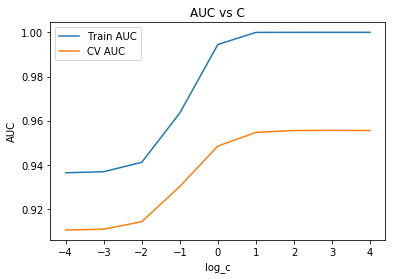

In [356]:
# Please write all the code with proper documentation
#finding the optimal hyper parameter 
train_auc = []
cv_auc = []
C = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
for i in C:
    lg_tfidf_l1 = LogisticRegression(C=i,class_weight='balanced')# The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies
    lg_tfidf_l1.fit(final_tfidf_train_data, y_train_data)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  lg_tfidf_l1.predict_proba(final_tfidf_train_data)[:,1]
    y_cv_pred =  lg_tfidf_l1.predict_proba(final_tfidf_cv_data)[:,1]
    train_auc_score=roc_auc_score(y_train_data,y_train_pred)
    train_auc.append(train_auc_score)
    cv_auc_score=roc_auc_score(y_cv_data, y_cv_pred)
    cv_auc.append(cv_auc_score)
    print("C = ",i ,"\t","cv_auc_score\t:",cv_auc_score, "\t","train_auc_score\t:",train_auc_score)

#plotting 
log_c = [math.log10(num) for num in C]
plt.plot(log_c, train_auc, label='Train AUC')
plt.plot(log_c, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log_c")
plt.ylabel("AUC")
plt.title("AUC vs C")
plt.show()

Here we got tfidf optimal C = 10 <br>
At    cv_auc    = 0.955<br>
      train_auc = 0.999


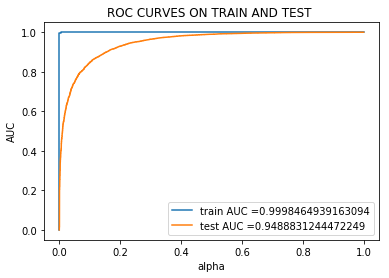

In [358]:
#applyng logistic regression with l1 penalty 
lg_tfidf_l1 = LogisticRegression(C=10,penalty= 'l1' ,class_weight='balanced')
lg_tfidf_l1.fit(final_tfidf_train_data, y_train_data)


tfidf_train_fpr, tfidf_train_tpr, tfidf_thresholds = roc_curve(y_train_data, lg_tfidf_l1.predict_proba(final_tfidf_train_data)[:,1])
tfidf_test_fpr, tfidf_test_tpr, tfidf_thresholds = roc_curve(y_test_data, lg_tfidf_l1.predict_proba(final_tfidf_test_data)[:,1])

plt.plot(tfidf_train_fpr, tfidf_train_tpr, label="train AUC ="+str(auc(tfidf_train_fpr, tfidf_train_tpr)))
plt.plot(tfidf_test_fpr, tfidf_test_tpr, label="test AUC ="+str(auc(tfidf_test_fpr, tfidf_test_tpr)))
plt.legend()
plt.xlabel("alpha")
plt.ylabel("AUC")
plt.title("ROC CURVES ON TRAIN AND TEST ")
plt.show()

TFIDF train confusion matrix
[[ 7040   512]
 [    0 35456]]


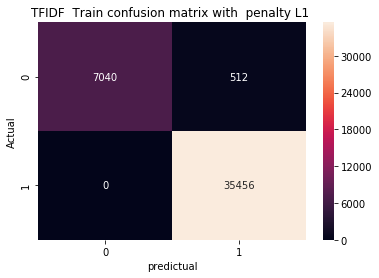

In [359]:
#TFIDF Train data confusion matrix
from sklearn.metrics import confusion_matrix
print("TFIDF train confusion matrix")
tfidf_cm_train = confusion_matrix(lg_tfidf_l1.predict(final_tfidf_train_data),y_train_data)
sns.heatmap(tfidf_cm_train, annot=True, fmt="d")
plt.title("TFIDF  Train confusion matrix with  penalty L1 ")
plt.xlabel("predictual")
plt.ylabel("Actual")
print(tfidf_cm_train)

Tfidf train confusion matrix with  penalty L1 <br>
35456+7040 are correctly predicted <br>
0+512 are in-correctly predicted 



tfidf test confusion matrix
[[ 3317  1404]
 [  911 20700]]


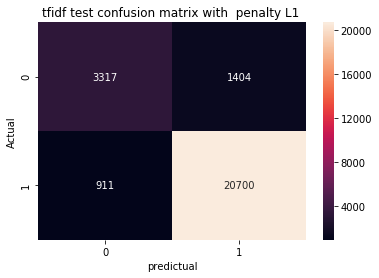

In [877]:
#tfidf Test data confusion matrix
from sklearn.metrics import confusion_matrix
print("tfidf test confusion matrix")
tfidf_cm_test = confusion_matrix(lg_tfidf_l1.predict(final_tfidf_test_data),y_test_data)
sns.heatmap(tfidf_cm_test, annot=True, fmt="d")
plt.title("tfidf test confusion matrix with  penalty L1 ")
plt.xlabel("predictual")
plt.ylabel("Actual")
print(tfidf_cm_test)

Tfidf test confusion matrix with  penalty L1 <br>
20700+3317 are correctly predicted <br>
911+1404 are in-correctly predicted 

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

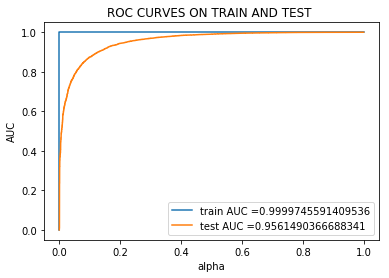

In [361]:
# Please write all the code with proper documentation
lg_tfidf_l2 = LogisticRegression(C=10,penalty= 'l2' ,class_weight='balanced')
lg_tfidf_l2.fit(final_tfidf_train_data, y_train_data)


tfidf_train_fpr, tfidf_train_tpr, tfidf_thresholds = roc_curve(y_train_data, lg_tfidf_l2.predict_proba(final_tfidf_train_data)[:,1])
tfidf_test_fpr, tfidf_test_tpr, tfidf_thresholds = roc_curve(y_test_data, lg_tfidf_l2.predict_proba(final_tfidf_test_data)[:,1])

plt.plot(tfidf_train_fpr, tfidf_train_tpr, label="train AUC ="+str(auc(tfidf_train_fpr, tfidf_train_tpr)))
plt.plot(tfidf_test_fpr, tfidf_test_tpr, label="test AUC ="+str(auc(tfidf_test_fpr, tfidf_test_tpr)))
plt.legend()
plt.xlabel("alpha")
plt.ylabel("AUC")
plt.title("ROC CURVES ON TRAIN AND TEST ")
plt.show()

TFIDF train confusion matrix
[[ 7040    92]
 [    0 35876]]


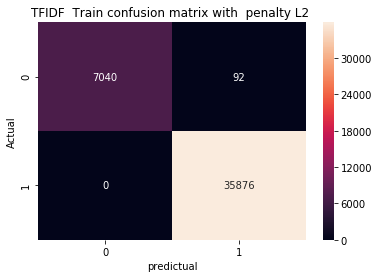

In [362]:
#TFIDF Train data confusion matrix
from sklearn.metrics import confusion_matrix
print("TFIDF train confusion matrix")
tfidf_cm_train = confusion_matrix(lg_tfidf_l2.predict(final_tfidf_train_data),y_train_data)
sns.heatmap(tfidf_cm_train, annot=True, fmt="d")
plt.title("TFIDF  Train confusion matrix with  penalty L2 ")
plt.xlabel("predictual")
plt.ylabel("Actual")
print(tfidf_cm_train)

Tfidf train confusion matrix with  penalty L2 <br>
35876+7040 are correctly predicted <br>
0+92 are in-correctly predicted 

tfidf test confusion matrix
[[ 3292  1097]
 [  936 21007]]


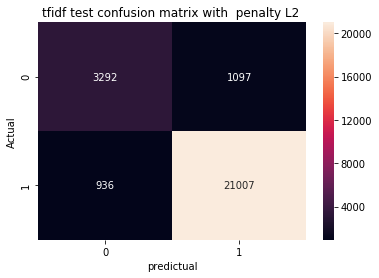

In [878]:
#tfidf Test data confusion matrix
from sklearn.metrics import confusion_matrix
print("tfidf test confusion matrix")
tfidf_cm_test = confusion_matrix(lg_tfidf_l2.predict(final_tfidf_test_data),y_test_data)
sns.heatmap(tfidf_cm_test, annot=True, fmt="d")
plt.title("tfidf test confusion matrix with  penalty L2 ")
plt.xlabel("predictual")
plt.ylabel("Actual")
print(tfidf_cm_test)

Tfidf test confusion matrix with  penalty L2 <br>
21007+3292 are correctly predicted <br>
936+1097 are in-correctly predicted 

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [351]:
# Please write all the code with proper documentation
def show_most_informative_features(tf_idf_vect, lg_tfidf_l1, n=10):
    feature_names = count_vect.get_feature_names()
    coefs_with_fns = sorted(zip(lg_tfidf_l1.coef_[0], feature_names))
    top = coefs_with_fns[:-(n + 1):-1]
    print("TFIDF Positive_Features")
    print("_________________")
    for (coef_1, fn_1) in top:
        print("%.4f\t%-15s" % (coef_1, fn_1))
show_most_informative_features(tf_idf_vect,lg_tfidf_l1)

TFIDF Positive_Features
_________________
33.9814	goodbewar      
29.6799	recalb         
21.7489	boot           
21.5021	gape           
16.6442	bestcancoffedrink
15.9290	finicki        
15.4644	yuban          
14.7945	trulitasti     
14.4996	snackchoicgenerat
14.1469	greatb         


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [352]:
# Please write all the code with proper documentation
def show_most_informative_features(tf_idf_vect, lg_tfidf_l1, n=10):
    feature_names = count_vect.get_feature_names()
    coefs_with_fns = sorted(zip(lg_tfidf_l1.coef_[0], feature_names))
    top = coefs_with_fns[:n]
    print("TFIDF Negative_Features")
    print("_________________")
    for (coef_2, fn_2) in top:
        print("%.4f\t%-15s" % (coef_2, fn_2))
show_most_informative_features(tf_idf_vect,lg_tfidf_l1)

TFIDF Negative_Features
_________________
-31.3295	promptship     
-23.4149	favoritteriyakijerki
-22.4870	cmonb          
-21.8418	sentenc        
-21.4565	nissin         
-19.2575	strangbrewwellreceiv
-18.3096	kenya          
-17.4724	commiss        
-17.2495	mariob         
-17.1965	refreshminttea 


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

C =  0.0001 	 cv_auc_score	: 0.8780970082566242 	 train_auc_score	: 0.8749579309607277
C =  0.001 	 cv_auc_score	: 0.8900462201082243 	 train_auc_score	: 0.8880162436844113
C =  0.01 	 cv_auc_score	: 0.8949077367364924 	 train_auc_score	: 0.8935094511883038
C =  0.1 	 cv_auc_score	: 0.8955376670878147 	 train_auc_score	: 0.8945156249210156
C =  1 	 cv_auc_score	: 0.8955982734701534 	 train_auc_score	: 0.8945797049239477
C =  10 	 cv_auc_score	: 0.8956082713113275 	 train_auc_score	: 0.8945740338476373
C =  100 	 cv_auc_score	: 0.8956103505083858 	 train_auc_score	: 0.8945738640312855
C =  1000 	 cv_auc_score	: 0.8956098638877976 	 train_auc_score	: 0.8945738245391106
C =  10000 	 cv_auc_score	: 0.8956104168657388 	 train_auc_score	: 0.8945738245391105


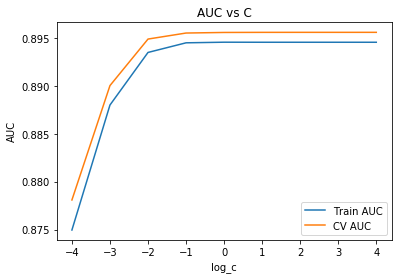

In [364]:
# Please write all the code with proper documentation
train_auc = []
cv_auc = []
C = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
for i in C:
    lg_avgw2v_l1 = LogisticRegression(C=i,class_weight='balanced')# The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies
    lg_avgw2v_l1.fit(final_avgw2v_train_data, y_train_data)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  lg_avgw2v_l1.predict_proba(final_avgw2v_train_data)[:,1]
    y_cv_pred =  lg_avgw2v_l1.predict_proba(final_avgw2v_cv_data)[:,1]
    train_auc_score=roc_auc_score(y_train_data,y_train_pred)
    train_auc.append(train_auc_score)
    cv_auc_score=roc_auc_score(y_cv_data, y_cv_pred)
    cv_auc.append(cv_auc_score)
    print("C = ",i ,"\t","cv_auc_score\t:",cv_auc_score, "\t","train_auc_score\t:",train_auc_score)

#plotting 
log_c = [math.log10(num) for num in C]
plt.plot(log_c, train_auc, label='Train AUC')
plt.plot(log_c, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log_c")
plt.ylabel("AUC")
plt.title("AUC vs C")
plt.show()

Here we got avgw2v optimal C = 0.1 <br>
At    cv_auc    = 0.895<br>
      train_auc = 0.894

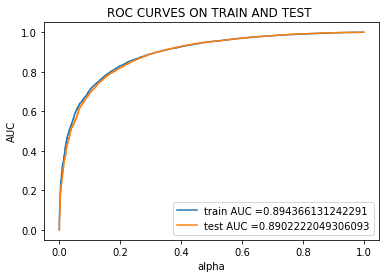

In [376]:
#applyng logistic regression with l1 penalty 
lg_avgw2v_l1 = LogisticRegression(C=0.1,penalty= 'l1' ,class_weight='balanced')
lg_avgw2v_l1.fit(final_avgw2v_train_data, y_train_data)


avgw2v_train_fpr, avgw2v_train_tpr, avgw2v_thresholds = roc_curve(y_train_data, lg_avgw2v_l1.predict_proba(final_avgw2v_train_data)[:,1])
avgw2v_test_fpr, avgw2v_test_tpr, avgw2v_thresholds = roc_curve(y_test_data, lg_avgw2v_l1.predict_proba(final_avgw2v_test_data)[:,1])

plt.plot(avgw2v_train_fpr, avgw2v_train_tpr, label="train AUC ="+str(auc(avgw2v_train_fpr, avgw2v_train_tpr)))
plt.plot(avgw2v_test_fpr, avgw2v_test_tpr, label="test AUC ="+str(auc(avgw2v_test_fpr, avgw2v_test_tpr)))
plt.legend()
plt.xlabel("alpha")
plt.ylabel("AUC")
plt.title("ROC CURVES ON TRAIN AND TEST ")
plt.show()

avgw2v train confusion matrix
[[ 5859  7213]
 [ 1181 28755]]


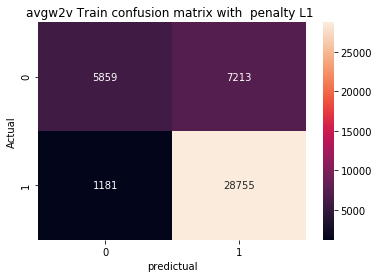

In [881]:
#Avgw2v Train data confusion matrix
from sklearn.metrics import confusion_matrix
print("avgw2v train confusion matrix")
avgw2v_cm_train = confusion_matrix(lg_avgw2v_l1.predict(final_avgw2v_train_data),y_train_data)
sns.heatmap(avgw2v_cm_train, annot=True, fmt="d")
plt.title("avgw2v Train confusion matrix with  penalty L1 ")
plt.xlabel("predictual")
plt.ylabel("Actual")
print(avgw2v_cm_train)

avgw2v train confusion matrix with  penalty L1 <br>
28755+5859 are correctly predicted <br>
1181+7213 are in-correctly predicted 

avgw2v test confusion matrix
[[ 3480  4452]
 [  748 17652]]


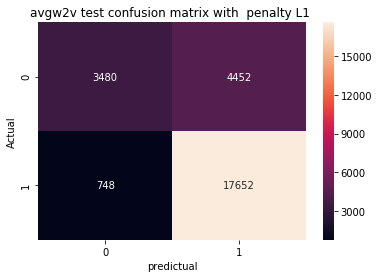

In [883]:
#avgw2v Test data confusion matrix
from sklearn.metrics import confusion_matrix
print("avgw2v test confusion matrix")
avgw2v_cm_test = confusion_matrix(lg_avgw2v_l1.predict(final_avgw2v_test_data),y_test_data)
sns.heatmap(avgw2v_cm_test, annot=True, fmt="d")
plt.title("avgw2v test confusion matrix with  penalty L1 ")
plt.xlabel("predictual")
plt.ylabel("Actual")
print(avgw2v_cm_test)

avgw2v test confusion matrix with  penalty L1 <br>
17652+3480 are correctly predicted <br>
748+4452 are in-correctly predicted

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

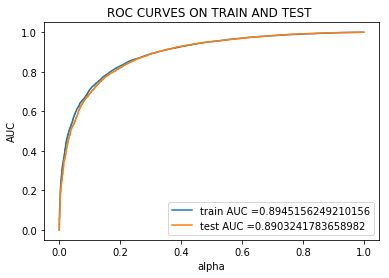

In [379]:
# Please write all the code with proper documentation
#applyng logistic regression with l2 penalty 
lg_avgw2v_l2 = LogisticRegression(C=0.1,penalty= 'l2' ,class_weight='balanced')
lg_avgw2v_l2.fit(final_avgw2v_train_data, y_train_data)


avgw2v_train_fpr, avgw2v_train_tpr, avgw2v_thresholds = roc_curve(y_train_data, lg_avgw2v_l2.predict_proba(final_avgw2v_train_data)[:,1])
avgw2v_test_fpr, avgw2v_test_tpr, avgw2v_thresholds = roc_curve(y_test_data, lg_avgw2v_l2.predict_proba(final_avgw2v_test_data)[:,1])

plt.plot(avgw2v_train_fpr, avgw2v_train_tpr, label="train AUC ="+str(auc(avgw2v_train_fpr, avgw2v_train_tpr)))
plt.plot(avgw2v_test_fpr, avgw2v_test_tpr, label="test AUC ="+str(auc(avgw2v_test_fpr, avgw2v_test_tpr)))
plt.legend()
plt.xlabel("alpha")
plt.ylabel("AUC")
plt.title("ROC CURVES ON TRAIN AND TEST ")
plt.show()

avgw2v train confusion matrix
[[ 5862  7231]
 [ 1178 28737]]


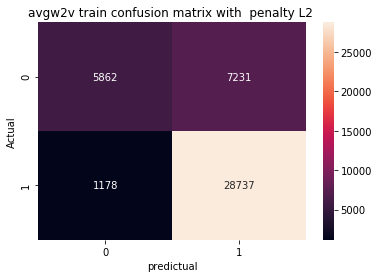

In [885]:
#avgw2v train data confusion matrix
from sklearn.metrics import confusion_matrix
print("avgw2v train confusion matrix")
avgw2v_cm_train = confusion_matrix(lg_avgw2v_l2.predict(final_avgw2v_train_data),y_train_data)
sns.heatmap(avgw2v_cm_train, annot=True, fmt="d")
plt.title("avgw2v train confusion matrix with  penalty L2 ")
plt.xlabel("predictual")
plt.ylabel("Actual")
print(avgw2v_cm_train)

avgw2v train confusion matrix with  penalty L2 <br>
28737+5862 are correctly predicted <br>
1178+7231 are in-correctly predicted

avgw2v test confusion matrix
[[ 3476  4429]
 [  752 17675]]


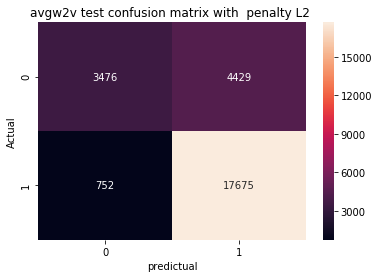

In [886]:
#avgw2v Test data confusion matrix
from sklearn.metrics import confusion_matrix
print("avgw2v test confusion matrix")
avgw2v_cm_test = confusion_matrix(lg_avgw2v_l2.predict(final_avgw2v_test_data),y_test_data)
sns.heatmap(avgw2v_cm_test, annot=True, fmt="d")
plt.title("avgw2v test confusion matrix with  penalty L2 ")
plt.xlabel("predictual")
plt.ylabel("Actual")
print(avgw2v_cm_test)

avgw2v test confusion matrix with  penalty L2 <br>
17675+3476 are correctly predicted <br>
752+4429 are in-correctly predicted

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

C =  0.0001 	 cv_auc_score	: 0.8507479358439416 	 train_auc_score	: 0.8461530731704696
C =  0.001 	 cv_auc_score	: 0.8654318005669572 	 train_auc_score	: 0.8617863428318859
C =  0.01 	 cv_auc_score	: 0.8719913354992372 	 train_auc_score	: 0.8690089956065746
C =  0.1 	 cv_auc_score	: 0.8727120205902441 	 train_auc_score	: 0.8701377175071023
C =  1 	 cv_auc_score	: 0.8727010273887763 	 train_auc_score	: 0.8701730353590817
C =  10 	 cv_auc_score	: 0.8726928433152489 	 train_auc_score	: 0.8701704012310184
C =  100 	 cv_auc_score	: 0.8726924230520137 	 train_auc_score	: 0.8701698878327453
C =  1000 	 cv_auc_score	: 0.8726921576226019 	 train_auc_score	: 0.8701698957311802
C =  10000 	 cv_auc_score	: 0.8726923788137783 	 train_auc_score	: 0.8701697140671759


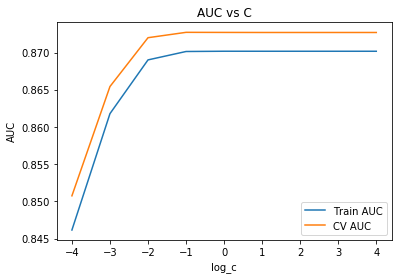

In [371]:
# Please write all the code with proper documentation
train_auc = []
cv_auc = []
C = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
for i in C:
    lg_tfidfw2v_l1 = LogisticRegression(C=i,class_weight='balanced')# The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies
    lg_tfidfw2v_l1.fit(final_tfidfw2v_train_data, y_train_data)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  lg_tfidfw2v_l1.predict_proba(final_tfidfw2v_train_data)[:,1]
    y_cv_pred =  lg_tfidfw2v_l1.predict_proba(final_tfidfw2v_cv_data)[:,1]
    train_auc_score=roc_auc_score(y_train_data,y_train_pred)
    train_auc.append(train_auc_score)
    cv_auc_score=roc_auc_score(y_cv_data, y_cv_pred)
    cv_auc.append(cv_auc_score)
    print("C = ",i ,"\t","cv_auc_score\t:",cv_auc_score, "\t","train_auc_score\t:",train_auc_score)

#plotting 
log_c = [math.log10(num) for num in C]
plt.plot(log_c, train_auc, label='Train AUC')
plt.plot(log_c, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log_c")
plt.ylabel("AUC")
plt.title("AUC vs C")
plt.show()

Here we got tfidfw2v optimal C = 0.1 <br>
At    cv_auc    = 0.872<br>
      train_auc = 0.870


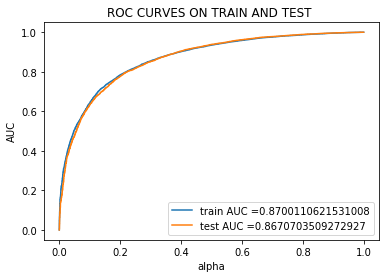

In [372]:
lg_tfidfw2v_l1 = LogisticRegression(C=0.1,penalty= 'l1' ,class_weight='balanced')
lg_tfidfw2v_l1.fit(final_tfidfw2v_train_data, y_train_data)


tfidfw2v_train_fpr, tfidfw2v_train_tpr, tfidfw2v_thresholds = roc_curve(y_train_data, lg_tfidfw2v_l1.predict_proba(final_tfidfw2v_train_data)[:,1])
tfidfw2v_test_fpr, tfidfw2v_test_tpr, tfidfw2v_thresholds = roc_curve(y_test_data, lg_tfidfw2v_l1.predict_proba(final_tfidfw2v_test_data)[:,1])

plt.plot(tfidfw2v_train_fpr, tfidfw2v_train_tpr, label="train AUC ="+str(auc(tfidfw2v_train_fpr, tfidfw2v_train_tpr)))
plt.plot(tfidfw2v_test_fpr, tfidfw2v_test_tpr, label="test AUC ="+str(auc(tfidfw2v_test_fpr, tfidfw2v_test_tpr)))
plt.legend()
plt.xlabel("alpha")
plt.ylabel("AUC")
plt.title("ROC CURVES ON TRAIN AND TEST ")
plt.show()

tfidfw2v train confusion matrix
[[ 5670  7979]
 [ 1370 27989]]


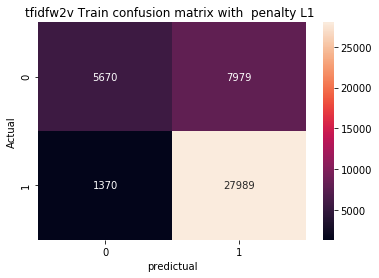

In [373]:
#tfidfw2v Train data confusion matrix
from sklearn.metrics import confusion_matrix
print("tfidfw2v train confusion matrix")
tfidfw2v_cm_train = confusion_matrix(lg_tfidfw2v_l1.predict(final_tfidfw2v_train_data),y_train_data)
sns.heatmap(tfidfw2v_cm_train, annot=True, fmt="d")
plt.title("tfidfw2v Train confusion matrix with  penalty L1 ")
plt.xlabel("predictual")
plt.ylabel("Actual")
print(tfidfw2v_cm_train)

tfidfw2v train confusion matrix with  penalty L1 <br>
27989+5670 are correctly predicted <br>
1370+7979 are in-correctly predicted

tfidfw2v train confusion matrix
[[ 3383  4948]
 [  845 17156]]


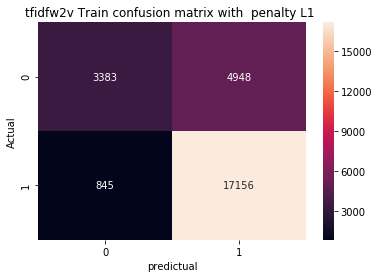

In [374]:
#tfidfw2v Test data confusion matrix
from sklearn.metrics import confusion_matrix
print("tfidfw2v train confusion matrix")
tfidfw2v_cm_test = confusion_matrix(lg_tfidfw2v_l1.predict(final_tfidfw2v_test_data),y_test_data)
sns.heatmap(tfidfw2v_cm_test, annot=True, fmt="d")
plt.title("tfidfw2v Train confusion matrix with  penalty L1 ")
plt.xlabel("predictual")
plt.ylabel("Actual")
print(tfidfw2v_cm_test)

tfidfw2v test confusion matrix with  penalty L1 <br>
17156+3383 are correctly predicted <br>
845+4948 are in-correctly predicted

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

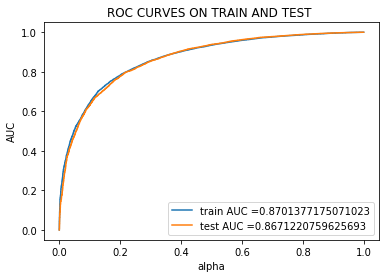

In [375]:
# Please write all the code with proper documentation
lg_tfidfw2v_l2 = LogisticRegression(C=0.1,penalty= 'l2' ,class_weight='balanced')
lg_tfidfw2v_l2.fit(final_tfidfw2v_train_data, y_train_data)


tfidfw2v_train_fpr, tfidfw2v_train_tpr, tfidfw2v_thresholds = roc_curve(y_train_data, lg_tfidfw2v_l2.predict_proba(final_tfidfw2v_train_data)[:,1])
tfidfw2v_test_fpr, tfidfw2v_test_tpr, tfidfw2v_thresholds = roc_curve(y_test_data, lg_tfidfw2v_l2.predict_proba(final_tfidfw2v_test_data)[:,1])

plt.plot(tfidfw2v_train_fpr, tfidfw2v_train_tpr, label="train AUC ="+str(auc(tfidfw2v_train_fpr, tfidfw2v_train_tpr)))
plt.plot(tfidfw2v_test_fpr, tfidfw2v_test_tpr, label="test AUC ="+str(auc(tfidfw2v_test_fpr, tfidfw2v_test_tpr)))
plt.legend()
plt.xlabel("alpha")
plt.ylabel("AUC")
plt.title("ROC CURVES ON TRAIN AND TEST ")
plt.show()

tfidfw2v train confusion matrix
[[ 5670  8008]
 [ 1370 27960]]


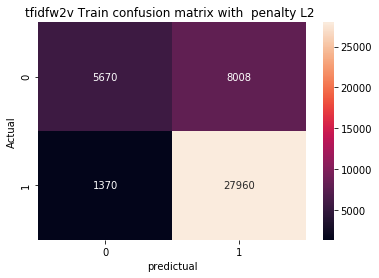

In [888]:
#tfidfw2v Train data confusion matrix
from sklearn.metrics import confusion_matrix
print("tfidfw2v train confusion matrix")
tfidfw2v_cm_train = confusion_matrix(lg_tfidfw2v_l2.predict(final_tfidfw2v_train_data),y_train_data)
sns.heatmap(tfidfw2v_cm_train, annot=True, fmt="d")
plt.title("tfidfw2v Train confusion matrix with  penalty L2 ")
plt.xlabel("predictual")
plt.ylabel("Actual")
print(tfidfw2v_cm_train)

tfidfw2v train confusion matrix with  penalty L2 <br>
27960+5670 are correctly predicted <br>
1370+8008 are in-correctly predicted

tfidfw2v train confusion matrix
[[ 3390  4967]
 [  838 17137]]


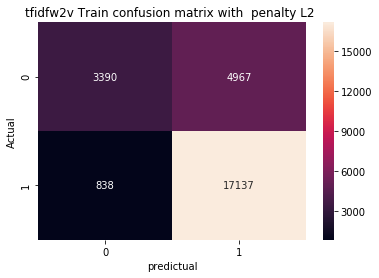

In [889]:
#tfidfw2v Test data confusion matrix
from sklearn.metrics import confusion_matrix
print("tfidfw2v train confusion matrix")
tfidfw2v_cm_test = confusion_matrix(lg_tfidfw2v_l2.predict(final_tfidfw2v_test_data),y_test_data)
sns.heatmap(tfidfw2v_cm_test, annot=True, fmt="d")
plt.title("tfidfw2v Train confusion matrix with  penalty L2 ")
plt.xlabel("predictual")
plt.ylabel("Actual")
print(tfidfw2v_cm_test)

tfidfw2v test confusion matrix with  penalty L2 <br>
17137+3390 are correctly predicted <br>
838+4967 are in-correctly predicted

# [6] Conclusions

In [897]:
# Please compare all your models using Prettytable library
#compare all your models using Prettytable library
#ref : http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Best Alpha","penalty", "Train_Auc","cv_auc","test_auc"]

x.add_row(["BOW", "LogisticRegression",0.1,"L1",0.95,0.93,0.93])
x.add_row(["TF-IDf","LogisticRegression",10,"L1",0.99,0.95,0.94 ])
x.add_row(["AVGW2V", "LogisticRegression",0.1,"L1",0.89,0.89,0.89])
x.add_row(["TFIDFW2v", "LogisticRegression",0.1,"L1",0.87,0.87,0.86])
x1 = PrettyTable()

x1.field_names = ["Vectorizer", "Model", "Best Alpha","penalty", "Train_Auc","cv_auc","test_auc"]
x1.add_row(["BOW", "LogisticRegression",0.1,"L2",0.95,0.93,0.93])
x1.add_row(["TF-IDf","LogisticRegression",10,"L2",0.99,0.95,0.95 ])
x1.add_row(["AVGW2V", "LogisticRegression",0.1,"L2",0.89,0.89,0.89])
x1.add_row(["TFIDFW2v", "LogisticRegression",0.1,"L2",0.87,0.87,0.86])

print(x)
print("*"*100)
print(x1)


+------------+--------------------+------------+---------+-----------+--------+----------+
| Vectorizer |       Model        | Best Alpha | penalty | Train_Auc | cv_auc | test_auc |
+------------+--------------------+------------+---------+-----------+--------+----------+
|    BOW     | LogisticRegression |    0.1     |    L1   |    0.95   |  0.93  |   0.93   |
|   TF-IDf   | LogisticRegression |     10     |    L1   |    0.99   |  0.95  |   0.94   |
|   AVGW2V   | LogisticRegression |    0.1     |    L1   |    0.89   |  0.89  |   0.89   |
|  TFIDFW2v  | LogisticRegression |    0.1     |    L1   |    0.87   |  0.87  |   0.86   |
+------------+--------------------+------------+---------+-----------+--------+----------+
****************************************************************************************************
+------------+--------------------+------------+---------+-----------+--------+----------+
| Vectorizer |       Model        | Best Alpha | penalty | Train_Auc | cv_auc | 

<h3>OBSERVATIONS</h3><br>
1.Here we got the best vectorizer is TFIDF which gives 0.95 Test auc score using L2 and L1 we got 0.94 Test auc both L1 and L2 are gives equal performance on TFIDF VEctoerizer <br>
2.After TFIDF next second vecterizer us BOW which also performs nearly with TFIDF both L1 and L2 penalit's<br>
3.We got the optimal C is 0.1 Which is from Bow vectorizer for  both L1 and L2 <br>
4.Performed feature Engineering by merging columns length of cleaned text and  cleaned summary text which improves the score results <br>
5.Pertubation test is done at Bow vectorizer with L1 penalty which says there is a much difference between weights after 99.8 % so it will be consider as multicolinear <br>
6.Printed the features have more difference in weight's
7.Overall the final result is in Logistic Regression TFIDF Vectorizer performs good , in confusion matrix also TFIDF performs good  predictions in both L1 and L2 penalty's <br>
8.Avgw2v and TFIDFw2v performs average performance's with L1 and L2 penalty's <br>
9.model performances BOW ,TFIDF ,AVGW2v, & TFIDFW2V gives similar performances in both L1 and L2 penalty's  <br>
10.We get good positive and negative features by using most_informative_features ,compare to naive bayes we get good positive and negative features in Logistic Regression 